<h1><center> Лабораторная работа №8(4) по курсу "Численные методы" </center></h1>
<h1><center> Решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. Схемы переменных направлений и дробных шагов. </center></h1>

|Студент| Зверев М.Е. |
|:-----:|:-:|
|Группа|М8О-406Б-19|
|Вариант|3|

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Начальные условия

In [ ]:
a_p = 1
X_MAX = np.pi / 4
Y_MAX = np.log(2)
T_MAX = 10

def ux0(y, t):
    return np.cosh(y) * np.exp(-3 * a_p * t)

def uxl(y, t):
    return 0

def uy0(x, t):
    return np.cos(2*x) * np.exp(-3 * a_p * t)

def uyl(x, t):
    return 5/4 * np.cos(2 * x) * np.exp(-3 * a_p * t)

def psi(x, y):
    return np.cos(2 * x) * np.cosh(y)

def U(x, y, t):
    return np.cos(2 * x) * np.cosh(y) * np.exp(-3 * a_p * t)

In [ ]:
def tma(a, b, c, d):
    size = len(a)
    p = np.zeros(size)
    q = np.zeros(size)
    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]
    
    for i in range(1, size):
        p[i] = -c[i] / (b[i] + a[i] * p[i - 1])
        q[i] = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])
    
    x = np.zeros(size)
    x[-1] = q[-1]
    
    for i in range(size - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]
    
    return x

In [ ]:
def alternating_directions(hx, hy, tau):
    x = np.arange(0, X_MAX, hx)
    y = np.arange(0, Y_MAX, hy)
    t = np.arange(0, T_MAX, tau)
    u = np.zeros((t.size, x.size, y.size))
    u[0] = np.array([[psi(xi, yj) for yj in y]  for xi in x])
    u[:, 0, :] = np.array([[ux0(yj, tk) for yj in y] for tk in t])
    u[:, -1, :] = np.array([[uxl(yj, tk) for yj in y] for tk in t])
    u[:, :, 0] = np.array([[uy0(xi, tk) for xi in x] for tk in t])
    u[:, :, -1] = np.array([[uyl(xi, tk) for xi in x] for tk in t])
    for k in range(1, t.size):
        k_half = np.zeros((x.size, y.size))
        for i in range(1, x.size - 1):
            a = np.zeros_like(y)
            b = np.zeros_like(y)
            c = np.zeros_like(y)
            d = np.zeros_like(y)

            s = (a_p * tau) / (2 * hx**4)
            for j in range(1, y.size - 1):
                a[j] = s
                b[j] = -2 * s - 1
                c[j] = s
                d[j] = (-a_p * tau / (2 * hy**2)) * (u[k - 1][i][j + 1] - 2 * u[k - 1][i][j] + u[k - 1][i][j - 1]) - u[k - 1][i][j]

            alpha = 0
            betta = 1
            gamma = 1
            delta = 0

            b[0] = betta - alpha / hy
            c[0] = alpha / hy
            d[0] = uy0(x[i], t[k] - tau / 2)
            a[-1] = -gamma / hy
            b[-1] = delta + gamma / hy
            d[-1] = uyl(x[i], t[k] - tau / 2)

            k_half[i] = tma(a, b, c, d)
            k_half[0] = ux0(y, t[k] - tau / 2)
            k_half[-1] = uxl(y, t[k] - tau / 2)

        for j in range(1, y.size - 1):
            a = np.zeros_like(x)
            b = np.zeros_like(x)
            c = np.zeros_like(x)
            d = np.zeros_like(x)
            s = (a_p * tau) / (2 * hx**2)
            for i in range(1, x.size - 1):
                a[i] = s
                b[i] = -2 * s - 1
                c[i] = s
                d[i] = (-a_p * tau / (2 * hy**2)) * (k_half[i][j + 1] - 2 * k_half[i][j] + k_half[i][j - 1]) - k_half[i][j]

            alpha = 0
            betta = 1
            gamma = 0
            delta = 1

            b[0] = betta - alpha / hx
            c[0] = alpha / hx
            d[0] = ux0(y[j], t[k])

            a[-1] = -gamma / hx
            b[-1] = delta + gamma / hx
            d[-1] = uxl(y[j], t[k])

            ans = tma(a, b, c, d)
            for i in range(ans.size):
                u[k][i][j] = ans[i]
            for j in range(y.size):
                u[k][0][j] = ux0(y[j], t[k])
                u[k][-1][j] = uxl(y[j], t[k])

            for i in range(x.size):
                u[k][i][0] = uy0(x[i], t[k])
                u[k][i][-1] = uyl(x[i], t[k])

    for j in range(len(y)):
        u[-1][0][j] = ux0(y[j], t[-1])
        u[-1][-1][j] = uxl(y[j], t[-1])

    for i in range(len(x)):
        u[-1][i][0] = uy0(x[i], t[-1])
        u[-1][i][-1] = uyl(x[i], t[-1])

    return u

In [ ]:
def fractional_steps(hx, hy, tau):
    x = np.arange(0, X_MAX, hx)
    y = np.arange(0, Y_MAX, hy)
    t = np.arange(0, T_MAX, tau)
    u = np.zeros((t.size, x.size, y.size))

    u[0] = np.array([[psi(xi, yj) for xi in x] for yj in y])
    u[:, 0, :] = np.array([[ux0(yj, tk) for yj in y] for tk in t])
    u[:, -1, :] = np.array([[uxl(yj, tk) for yj in y] for tk in t])
    u[:, :, 0] = np.array([[uy0(xi, tk) for xi in x] for tk in t])
    u[:, :, -1] = np.array([[uyl(xi, tk) for xi in x] for tk in t])
    
    for k in range(1, t.size):
        k_half = u[k].copy()
        for j in range(1, y.size - 1):
            a = np.zeros_like(x)
            b = np.zeros_like(x)
            c = np.zeros_like(x)
            d = np.zeros_like(x)

            s = a_p * tau / hx**4
            for i in range(1, x.size - 1):
                a[i] = s
                b[i] = -2 * s - 1
                c[i] = s
                d[i] = -u[k - 1][i][j]

            alpha = 1
            betta = 1
            gamma = 0
            delta = 1

            b[0] = betta - alpha / hx
            c[0] = alpha / hx
            d[0] = ux0(y[j], t[k] - tau / 2)

            a[-1] = - gamma / hx
            b[-1] = delta + gamma / hx
            d[-1] = uxl(y[j], t[k] - tau / 2)

            ans = tma(a, b, c, d)

            for i in range(1, x.size - 1):
                k_half[i] = ans[i]

        for j in range(y.size):
            k_half[0][j] = ux0(y[j], t[k] - tau / 2)
            k_half[-1][j] = uxl(y[j], t[k] - tau / 2)

        for i in range(1, x.size):
            a = np.zeros_like(y)
            b = np.zeros_like(y)
            c = np.zeros_like(y)
            d = np.zeros_like(y)

            tmp = a_p * tau / hy**2
            for j in range(1, y.size - 1):
                a[j] = s
                b[j] = -2 * s - 1
                c[j] = s
                d[j] = -k_half[i][j]

            alpha = 0
            betta = 1
            gamma = 1
            delta = 0

            b[0] = betta - alpha / hy
            c[0] = alpha / hy
            d[0] = uy0(x[i], t[k])

            a[-1] = -gamma / hy
            b[-1] = delta + gamma / hy
            d[-1] = uyl(x[i], t[k])

            ans = tma(a, b, c, d)

            for j in range(y.size):
                u[k][i][j] = ans[j]

        for i in range(len(x)):
            u[k][i][0] = uy0(x[i], t[k])
            u[k][i][-1] = uyl(x[i], t[k])

    return u

In [ ]:
def analitic(nx, ny, nt):
    x = np.arange(0, X_MAX, hx)
    y = np.arange(0, Y_MAX, hy)
    t = np.arange(0, T_MAX, tau)
    return np.array([[[U(xi, yi, ti) for xi in x] for yi in y] for ti in t])

In [ ]:
def plot_sols(nx, ny, nt, u):
    s = analitic(nx, ny, nt)
    n = 6
    x = np.arange(0, X_MAX, hx)
    y = np.arange(0, Y_MAX, hy)
    t = np.arange(0, T_MAX, tau)
    px = np.linspace(x.size // nx, nx - 1, n, dtype = np.int32)
    py = np.linspace(y.size // ny, ny - 1, n, dtype = np.int32)
    pt = np.linspace(t.size // nt, nt - 1, n, dtype = np.int32)
    xy = np.array(list(zip(px, py)))
    xt = np.array(list(zip(px, pt)))
    yt = np.array(list(zip(py, pt)))
    fig, ax = plt.subplots(3, 2)
    fig.suptitle('Сравнение решений в плоскости Oxy')
    fig.set_figheight(14)
    fig.set_figwidth(16)
    k = 0
    for i in range(3):
        for j in range(2):
            ax[i][j].set_title(f'Решение при x = {x[xy[k][0]]}, y = {y[xy[k][1]]}')
            ax[i][j].plot(t, u[:,xy[k][0],xy[k][1]], label = 'Численный метод')
            ax[i][j].plot(t, s[:,xy[k][0],xy[k][1]], label = 'Aналитическое решение')
            ax[i][j].grid(True)
            ax[i][j].set_xlabel('t')
            ax[i][j].set_ylabel('u')
            k += 1
    plt.legend(bbox_to_anchor = (1.05, 2), loc = 'upper left', borderaxespad = 0.)
    plt.show()

##Тестирование

###Схема переменных направлений

In [ ]:
nx = 10
ny = 10
nt = 30
hx = X_MAX / nx
hy = Y_MAX / ny
tau = T_MAX / nt
res = alternating_directions(hx, hy, tau)

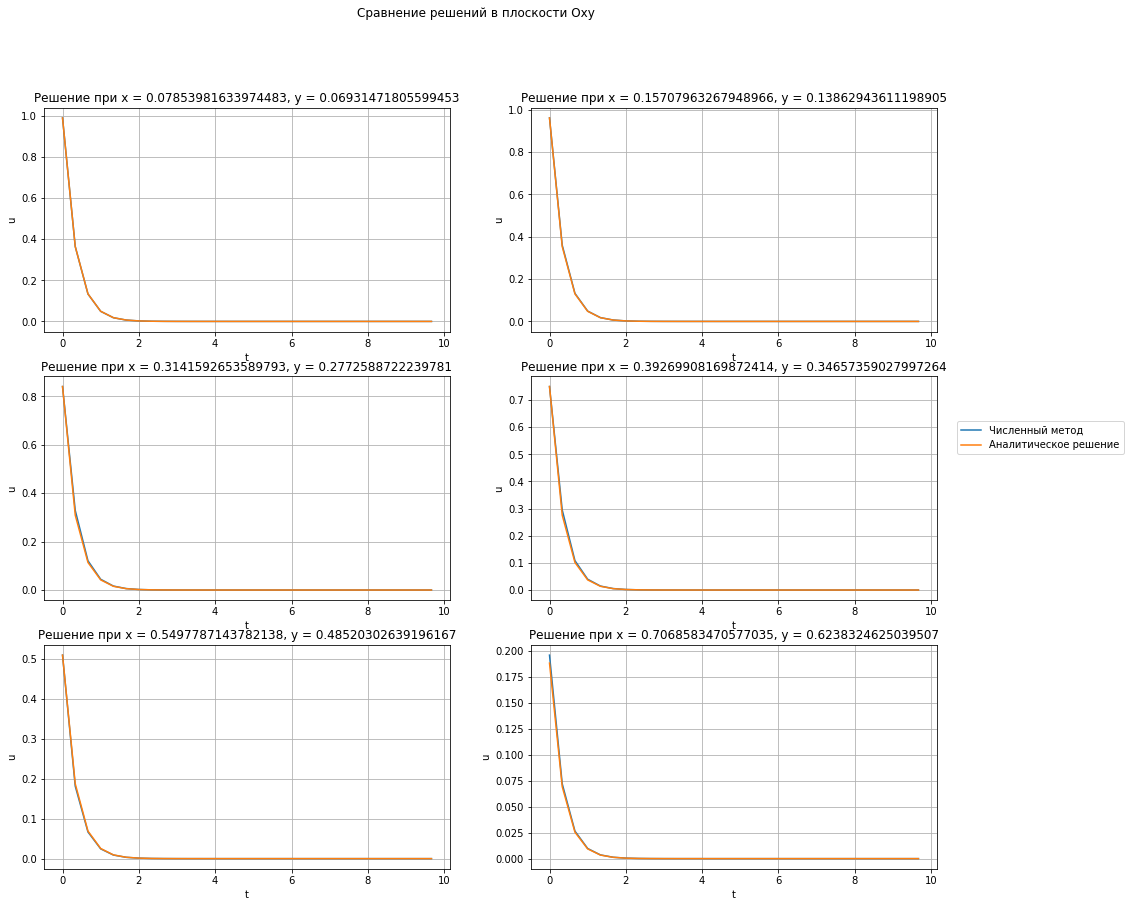

In [ ]:
x = np.arange(0, X_MAX, hx)
y = np.arange(0, Y_MAX, hy)
t = np.arange(0, T_MAX, tau)
sol = np.array([[[U(xi, yi, ti) for yi in y] for xi in x] for ti in t])
plot_sols(nx, ny, nt, res)

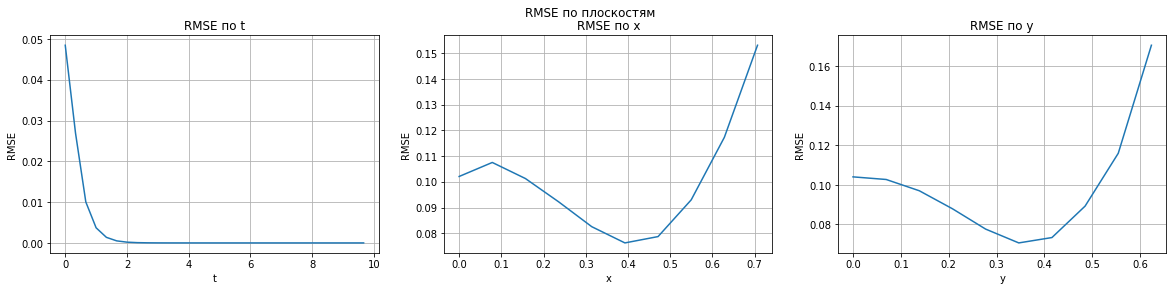

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.suptitle('RMSE по плоскостям')
fig.set_figheight(4)
fig.set_figwidth(20)
ax[0].set_title(f'RMSE по t')
ax[1].set_title(f'RMSE по x')
ax[2].set_title(f'RMSE по y')
ax[0].set_xlabel('t')
ax[1].set_xlabel('x')
ax[2].set_xlabel('y')
ax[0].set_ylabel('RMSE')
ax[1].set_ylabel('RMSE')
ax[2].set_ylabel('RMSE')
ax[0].plot(t, [np.sqrt(mean_squared_error(sol[i], res[i])) for i in range(t.size)])
ax[1].plot(x, [np.sqrt(mean_squared_error(sol[:, i], res[:, :, i])) for i in range(x.size)])
ax[2].plot(y, [np.sqrt(mean_squared_error(sol[:, :, i], res[:, i, :])) for i in range(y.size)])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

###Схема дробных шагов

In [ ]:
nx = 30
ny = 30
nt = 130
hx = X_MAX / nx
hy = Y_MAX / ny
tau = T_MAX / nt
res = fractional_steps(hx, hy, tau)

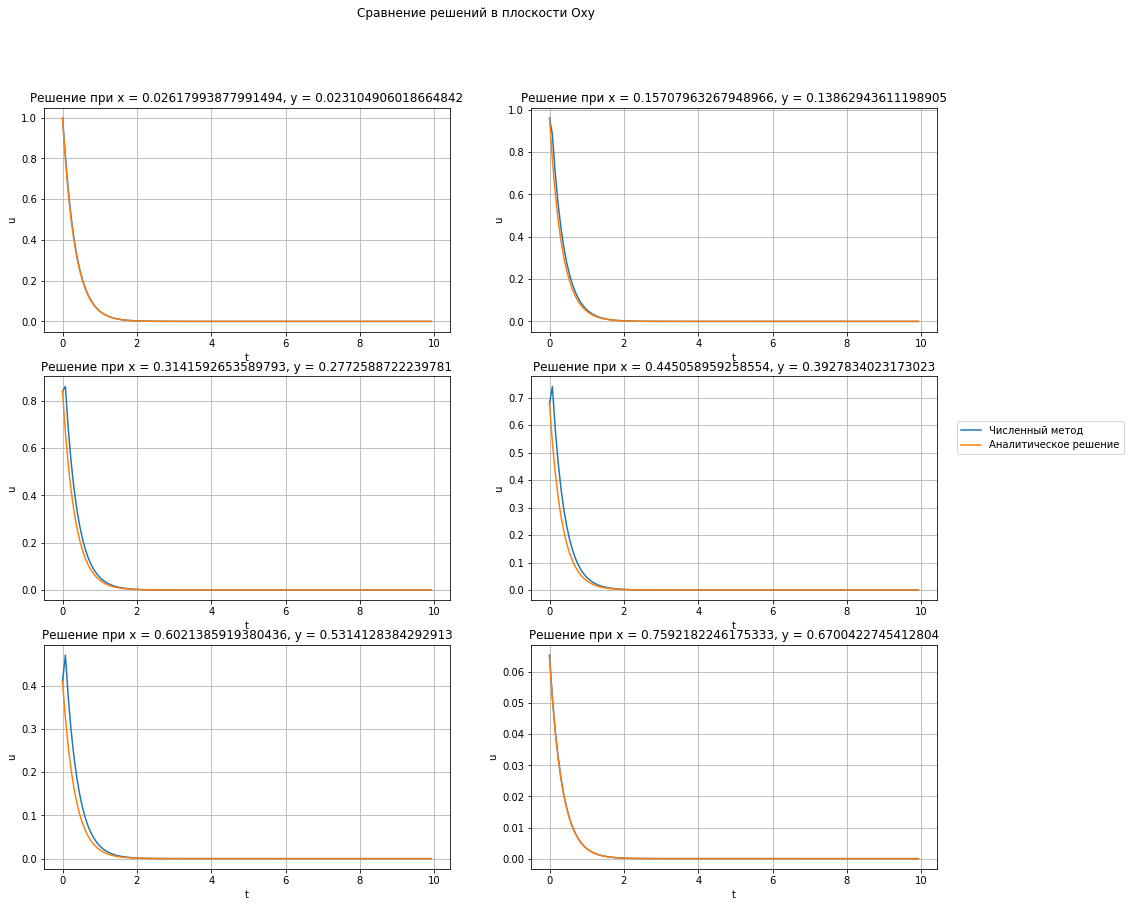

In [ ]:
x = np.arange(0, X_MAX, hx)
y = np.arange(0, Y_MAX, hy)
t = np.arange(0, T_MAX, tau)
sol = np.array([[[U(xi, yi, ti) for yi in y] for xi in x] for ti in t])
plot_sols(nx, ny, nt, res)

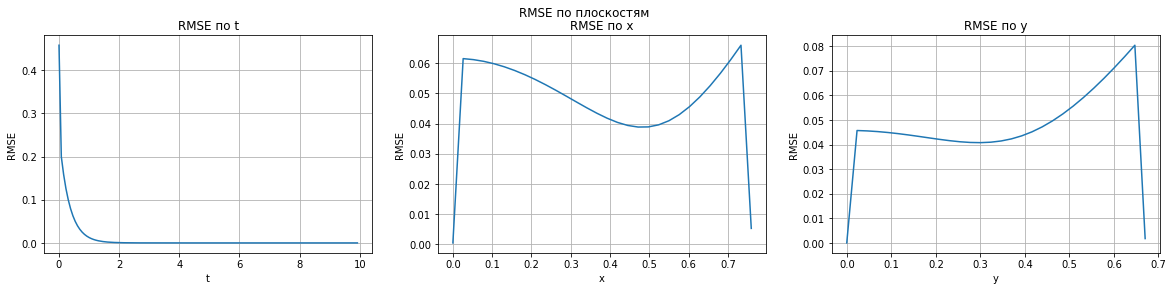

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.suptitle('RMSE по плоскостям')
fig.set_figheight(4)
fig.set_figwidth(20)
ax[0].set_title(f'RMSE по t')
ax[1].set_title(f'RMSE по x')
ax[2].set_title(f'RMSE по y')
ax[0].set_xlabel('t')
ax[1].set_xlabel('x')
ax[2].set_xlabel('y')
ax[0].set_ylabel('RMSE')
ax[1].set_ylabel('RMSE')
ax[2].set_ylabel('RMSE')
ax[0].plot(t, [np.sqrt(mean_squared_error(sol[i], res[i])) for i in range(t.size)])
ax[1].plot(x, [np.sqrt(mean_squared_error(sol[:, i], res[:, i])) for i in range(x.size)])
ax[2].plot(y, [np.sqrt(mean_squared_error(sol[:, :, i], res[:, :, i])) for i in range(y.size)])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)